# <center> Project-4: Token Classification

**Case Description**

In this notebook we will train a Named Entity Recognition (NER) model using multilingual language model (mBERT).

**Task**
* Using the data to build a model that predicts NER tags.

**Data**: There are 3 files: *train*, *dev* and *test* txt files with context and tags.

**ML/DL task**: Token Classification (NER)

*Training on GPU*

# 0. Install and Import

In [1]:
%%capture
!pip install transformers # the huggingface library containing the general-purpose architectures for NLP
!pip install datasets # the huggingface library containing datasets and evaluation metrics for NLP
!pip install seqeval -qq # evaluation metrics for training
# !pip install --upgrade wandb -qq # experiment tracking

In [2]:
import numpy as np
import json
import copy
import random
from tqdm.auto import tqdm #progress bar

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import torch # an open source machine learning framework used to create and train models on the GPU
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification


import warnings
warnings.filterwarnings("ignore")

In [3]:
model_name = "Babelscape/wikineural-multilingual-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)

metric = load_metric("seqeval")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The repository for seqeval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/seqeval.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [4]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Set random seeds
def set_seed(seed):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    np.random.seed(seed)
    random.seed(seed)
#     tf.random.set_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    
set_seed(RANDOM_SEED)

In [5]:
# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# 1. Data Loading: dataset exploration

In [6]:
# Reading dataset's file
path_to_files = '../input/factrueval2016/'

train_file = f'{path_to_files}train.txt'
dev_file = f'{path_to_files}dev.txt'
test_file = f'{path_to_files}test.txt'

In [7]:
# read all lines from train
with open(train_file,'r') as train:
    train_words = train.readlines()

# read all lines from dev
with open(dev_file,'r') as dev:
    dev_words = dev.readlines()

# read all lines from test    
with open(test_file,'r') as test:
    test_words = test.readlines()    

In [8]:
def get_tokens_ners(words):
    """
    Read text
    
    Getting tokens and NER tags separately
    """
    tokens, ner_tags = [],[]
    
    for word in words:
        
        if len(word.strip())>0: # remnove spaces
            #print(word)
            token, ner = word.split()
            ner = ner.strip('\n')
            tokens.append(token)
            ner_tags.append(ner)
            
    return tokens, ner_tags

In [9]:
# train_words - tokens
example_1_tokens = ' '.join(get_tokens_ners(train_words)[0])

example_1_tokens[:500]

'" Если Миронов занял столь оппозиционную позицию , то мне представляется , что для него было бы порядочным и правильным уйти в отставку с занимаемого им поста , поста , который предоставлен ему сегодня " Единой Россией \'\' и никем больше \'\' , - заключает Исаев . Источник " Ъ \'\' в руководстве столичной мэрии считает маловероятным , что господина Митволя назначили с целью " укрепления границ с Подмосковьем \'\' . В Ханты-Мансийском автономном округе с должности снят начальник УВД Николай Гудожников .'

In [10]:
# train_words - NER tags
example_1_ner = ' '.join(get_tokens_ners(train_words)[1])

example_1_ner[:500]

'O O B-PER O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-ORG I-ORG O O O O O O O O B-PER O O O B-ORG O O O O O O O O O O B-PER O O O O O O O B-LOC O O O B-LOC I-LOC I-LOC O O O O B-ORG B-PER I-PER O O O O O O O O O B-ORG I-ORG I-ORG O I-ORG O O O O O O O O O O O O O O B-LOC I-LOC O O O O O O B-PER O O O O O O O B-ORG O O O O O O O O O O O B-PER O O O O B-LOC O B-LOC B-PER I-PER O O O O O O B-LOC I-LOC O O O O B-LOC O O O B-ORG O O O O O O O O O O O O O O O O O O O O O O O O O '

In [11]:
# test_words
example_2 = ' '.join(get_tokens_ners(test_words)[0])

example_2[:500]

"Тогда замешанные в скандале прокуроры отделались выговорами и благополучно вернулись на работу . Символичным назвал председатель РФМ , депутат Государственной думы РФ Леонид Слуцкий ( ЛДПР ) установку памятника Твардовскому в день годовщины Великой Отечественной войны . На посту гендиректора Yahoo ! B-ORG Кэрол Бартц сменила Джерри Янга - основателя компании . Считаю невозможным руководить областью с таким уровнем доверия населения '' , - сообщил тогда сам В.Позгалев . Боксер победила Карли Фиор"

In [12]:
# dev_words
example_3 = ' '.join(get_tokens_ners(dev_words)[0])

example_3[:500]

'как акционерный коммерческий Московский муниципальный банк - Банк Москвы , контрольный пакет акций которого принадлежал правительству Москвы . Управлять ЦАО и САО вместо Алексея Александрова и Олега Митволя будут бывшие заместители Юрия Лужкова . О задержании Шакирьянова стало известно 8 февраля 2011 года . После майского ухода вице-премьера Владислава Суркова был скорректирован и список обязанностей Дмитрия Козака . Армяне со мной согласились , с Ильхамом Алиевым я поговорил , он сказал , что т'

***

# 2. Steps before model building

## 2.1 Steps before model building: Create dataset

In [13]:
# example
dataset = load_dataset('conll2003')
dataset['train'][0]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [14]:
"""
Create label2id/ id2label dict
"""
label2id = {'O': 0,
            'B-PER': 1, 'I-PER': 2,
            'B-ORG': 3, 'I-ORG': 4,
            'B-LOC': 5, 'I-LOC': 6,
            'B-MISC': 7, 'I-MISC': 8}

id2label={0: 'O',
          1: 'B-PER', 2: 'I-PER',
          3: 'B-ORG', 4: 'I-ORG',
          5: 'B-LOC', 6: 'I-LOC',
          7: 'B-MISC', 8: 'I-MISC'}

* **O** means the word doesn’t correspond to any entity.
* **B-PER/I-PER** means the word corresponds to the beginning of/is inside a person entity.
* **B-ORG/I-ORG** means the word corresponds to the beginning of/is inside an organization entity.
* **B-LOC/I-LOC** means the word corresponds to the beginning of/is inside a location entity.
* **B-MISC/I-MISC** means the word corresponds to the beginning of/is inside a miscellaneous entity.

In [15]:
def get_dict_tokens_ners(words):
    """
    Getting dictionary with tokens and ner_tags for model training stage
    """
    
    idx, tokens, ner_tags  = 0, [],[]
    dataset_json = []
    
    for line in words:
        line = line.strip('\n')
        
        if len(line.strip()) == 0:
            cur_tokens = copy.deepcopy(tokens)
            cur_ner_tags = copy.deepcopy(ner_tags)

            dict_ner = {'id': idx, 'tokens': cur_tokens,'length': len(cur_tokens), 'ner_tags_str': cur_ner_tags, 'ner_tags': [label2id[i] for i in cur_ner_tags]}
            dataset_json.append(dict_ner)

            idx += 1
            tokens.clear()
            ner_tags.clear()
            
        else:
            token, ner = line.split()
            
            # check if ner tag not in token
            if token not in list(id2label.keys()):
                ner = ner.strip('\n')
                tokens.append(token)
                ner_tags.append(ner)
                
    data = {}
    data['data'] = dataset_json
    
    return data

In [16]:
%%time

names = ['train', 'dev', 'test']

for idx, words in enumerate([train_words, dev_words, test_words]):
    print(names[idx])
    
    data = get_dict_tokens_ners(words)
    
    with open(f'{names[idx]}_data.json', 'w') as f:
        json.dump(data, f)

train
dev
test
CPU times: user 1.95 s, sys: 32.3 ms, total: 1.99 s
Wall time: 1.99 s


In [17]:
# Let's see what the dictionary looks like
data["data"][0]

{'id': 0,
 'tokens': ['Тогда',
  'замешанные',
  'в',
  'скандале',
  'прокуроры',
  'отделались',
  'выговорами',
  'и',
  'благополучно',
  'вернулись',
  'на',
  'работу',
  '.'],
 'length': 13,
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [18]:
"""
Create Dataset
"""
data_files = {"train": 'train_data.json', 'val':'dev_data.json', 'test':'test_data.json'}

load_json_dataset = load_dataset('json', data_files=data_files,field ='data')
load_json_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 7746
    })
    val: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
    test: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
})

In [19]:
MAX_LEN = max([max(load_json_dataset['train']['length']),
               max(load_json_dataset['val']['length']),
               max(load_json_dataset['test']['length'])])

MAX_LEN

222

In [20]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes
num_labels

9

## 2.2 Steps before model building: Processing the examples' in Dataset

The dataset is going to be used to train and evaluate the NER model. In order to do so, we must first modify and/or add the examples so that they can be sent to the model. With `datasets` this can be done using the `.map` method. The map method accepts a `dict` and returns a `dict`.

If the returned dictionary contains new key-values, these are then added to input dictionary. In addition, if the returned dictionary contains keys that are also in the input dictionary, it overrides them.

With the `add_encodings` method we want to add the following values to our dataset examples:

* `input_ids`. The input ids that will be sent to the model. This is generated by the `tokenizer`.
* `attention_mask`. The attention_mask that will be sent to the model. This is generated by the `tokenizer`.
* `labels`. The labels that will be sent to the model to calculate the loss value. This will be created from the `ner_tags` attribute of the examples.

In [21]:
def add_encodings(example):
    """Processing the example
    
    Args:
        example (dict): The dataset example.
    
    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.
    """
    # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True
    
    try:
        encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', max_length = MAX_LEN, is_split_into_words=True)
        
        # extend the ner_tags so that it matches the max_length of the input_ids
        labels = example['ner_tags'] + [0] * (MAX_LEN - len(example['ner_tags']))
        
        # return the encodings and the extended ner_tags
        return { **encodings, 'labels': labels}
    
    except Exception as ex:
        print(ex)
        #print(example['tokens'])
        return 

In [22]:
load_json_dataset = load_json_dataset.map(add_encodings)
load_json_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/7746 [00:00<?, ? examples/s]

Map:   0%|          | 0/2582 [00:00<?, ? examples/s]

Map:   0%|          | 0/2582 [00:00<?, ? examples/s]

***

In [23]:
# def align_labels_with_tokens(labels, word_ids):
#     new_labels = []
#     current_word = None
    
#     for word_id in word_ids:
        
#         if word_id != current_word:
#             # Start of a new word!
#             current_word = word_id
#             label = -100 if word_id is None else labels[word_id]
#             new_labels.append(label)
            
#         elif word_id is None:
#             # Special token
#             new_labels.append(-100)
        
#         else:
#             # Same word as previous token
#             label = labels[word_id]
        
#             # If the label is B-XXX we change it to I-XXX
#             if label % 2 == 1:
#                 label += 1
#             new_labels.append(label)

#     return new_labels


# def tokenize_and_align_labels(examples):
#     tokenized_inputs = tokenizer(
#         examples["tokens"], truncation=True, is_split_into_words=True
#     )
    
#     all_labels = examples["ner_tags"]
#     new_labels = []
    
#     for i, labels in enumerate(all_labels):
#         word_ids = tokenized_inputs.word_ids(i)
#         new_labels.append(align_labels_with_tokens(labels, word_ids))

#     tokenized_inputs["labels"] = new_labels
    
#     return tokenized_inputs

In [24]:
# """
# Modify/format all datasets so that they include the 'input_ids', 'attention_mask' 
# and 'labels' used to train and evaluate the model
# """
# #load_json_dataset = load_json_dataset.map(add_encodings)

# tokenized_datasets = load_json_dataset.map(
#     tokenize_and_align_labels,
#     batched=True,
#     remove_columns=load_json_dataset["train"].column_names,
# )

***

In [23]:
"""
We will use DataCollatorForTokenClassification to create a batch of examples.
This pads the text and labels to the length of the longest element in its batch, so each sample is a uniform length
"""
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [24]:
load_json_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7746
    })
    val: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2582
    })
    test: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2582
    })
})

In [25]:
batch = data_collator([load_json_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [26]:
label_names = list(label2id.keys())
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [27]:
labels = load_json_dataset["train"]["ner_tags"][0]
labels = [label_names[i] for i in labels]
labels

['O',
 'O',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'O']

In [28]:
predictions = labels.copy()
predictions[2] = "O"

metric.compute(predictions=[predictions], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.9787234042553191}

# 3. Model

Since Named Entity Recognition can be seen as token classification we will use the AutoModelForTokenClassification model provided by huggingface.

We will import the pretrained mBert model and provide it the number of labels we will have. In addition, we will change the model configurations so that it will be easy for us to assign the labels and/or label ids.

In this notebook, we will fine-tune the model to correctly identify named entities. During training we will update both the mBERT model weights as well as the classifier

In [29]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

Outputing the model will show us its architecture. As we can see, the first part is the architecture of the ruBert model, with an added dropout and classifier layers at the end. When we load a pretrained model, the ruBert weights are already set, but it requires fine-tuning for specific tasks.

In [30]:
model.config.num_labels

9

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 3.1: Functions to train and evaluate the Model

Training and Evaluating process:

* Transfer-learning mBERT on our classes
* Parameters:
    * **number of epochs** (10). This determines the number of times we will go through the whole dataset during training.
    * **batch size** (16) - meaning that there will be BS examples processed in parallel.
* To train the dataset we will use the dataset['train'] data.
* To evaluate the model we will use the dataset['val'] data.
    - The model will be evaluated by creating the **confusion matrix**. The confusion matrix will show the missmatch between the true labels and the predicted ones. First we create a tensor of size `(num_labels, num_labels)` in which we will store the results. Then, for each batch in the test dataset we will compare the true label with the predicted one and store it in the confusion matrix.

In [32]:
# batch the train data so that each batch contains 16 examples (using 'batch_size')
train_data = torch.utils.data.DataLoader(load_json_dataset['train'], batch_size=16) #collate_fn=data_collator)
test_data = torch.utils.data.DataLoader(load_json_dataset['val'], batch_size=16)#, collate_fn=data_collator)

In [33]:
for batch in train_data:
    break
    
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([16, 222]),
 'attention_mask': torch.Size([16, 222]),
 'labels': torch.Size([16, 222])}

In [34]:
for batch in test_data:
    break
    
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([16, 222]),
 'attention_mask': torch.Size([16, 222]),
 'labels': torch.Size([16, 222])}

### Functions to train and evaluate the model

In [35]:
"""
Function to train the model
"""
def train_loop(
    train_loader,
    model,
    num_epochs,
    optimizer,
    device
):

    model.train().to(device)
    
    for i, batch in enumerate(tqdm(train_loader)):
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        train_loss = outputs[0]

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch number: {epoch+1}, Train loss: {train_loss.item()}", '\n', 50*"-")
    
    return train_loss.item()


"""
Function to evaluate the Model
"""
def model_valid(valid_data, model, num_labels, num_epochs):
    model = model.eval()
    
    # create the confusion matrix
    confusion = torch.zeros(num_labels, num_labels)
    
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdm(valid_data)):
        # do not calculate the gradients
        with torch.no_grad():
            # move the batch tensors to the same device as the model
            batch = { k: v.to(device) for k, v in batch.items() }
            # send 'input_ids', 'attention_mask' and 'labels' to the model
            outputs = model(**batch)
            val_loss = outputs[0]
        
        # get the sentence lengths
        s_lengths = batch['attention_mask'].sum(dim=1)
        
        # iterate through the examples
        for idx, length in enumerate(s_lengths):
            # get the true values
            true_values = batch['labels'][idx][:length]
            # get the predicted values
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            
            # go through all true and predicted values and store them in the confusion matrix
            for true, pred in zip(true_values, pred_values):
                confusion[true.item()][pred.item()] += 1
    
    print(f"Epoch number: {epoch+1}, Val loss: {val_loss.item()}", '\n', 50*"-")
    
    return confusion, val_loss.item()

# 3.2 Model training and validating

In [36]:
"""
PARAMETERS

Loss, optimizer, other parameters
"""
num_epochs = 10
learning_rate = 1e-5 #1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [37]:
# Model training and evaluating
train_loss_full = []
val_loss_full = []

for epoch in range(num_epochs):
    
    train_loss = train_loop(train_data, model, num_epochs, optimizer, device)
    train_loss_full.append(train_loss)
    
    if (epoch+1) % 2 == 0: pass
    
    else:
        confusion, val_loss = model_valid(test_data, model, num_labels, num_epochs)
        val_loss_full.append(val_loss)
        print(50 * '-')

  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 1, Train loss: 0.03897949680685997 
 --------------------------------------------------


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch number: 1, Val loss: 0.06863335520029068 
 --------------------------------------------------
--------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 2, Train loss: 0.026205021888017654 
 --------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 3, Train loss: 0.021788978949189186 
 --------------------------------------------------


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch number: 3, Val loss: 0.043993815779685974 
 --------------------------------------------------
--------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 4, Train loss: 0.031362708657979965 
 --------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 5, Train loss: 0.013385825790464878 
 --------------------------------------------------


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch number: 5, Val loss: 0.038150522857904434 
 --------------------------------------------------
--------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 6, Train loss: 0.011755621992051601 
 --------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 7, Train loss: 0.008620594628155231 
 --------------------------------------------------


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch number: 7, Val loss: 0.03220982477068901 
 --------------------------------------------------
--------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 8, Train loss: 0.009681002236902714 
 --------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 9, Train loss: 0.004912831354886293 
 --------------------------------------------------


  0%|          | 0/162 [00:00<?, ?it/s]

Epoch number: 9, Val loss: 0.023863036185503006 
 --------------------------------------------------
--------------------------------------------------


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch number: 10, Train loss: 0.0033156685531139374 
 --------------------------------------------------


**Some observations:**
* The training loss is rapidly decreasing at epoch 4
* The validation loss gets higher than training loss but here also there is a tendency to decreasing of value epoch by epoch.

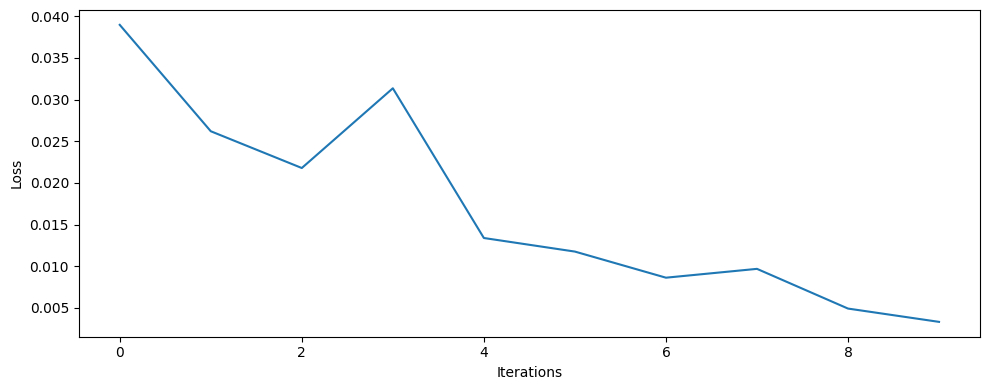

In [38]:
"""
Visualize the Training Loss
"""
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss_full)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
fig.tight_layout()

plt.show()

In [39]:
"""
And the last step is confusion matrix.

Now we will normalize the confusion matrix by its rows so that we will see how did the model perform
"""
# Normalize by dividing every row by its sum
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

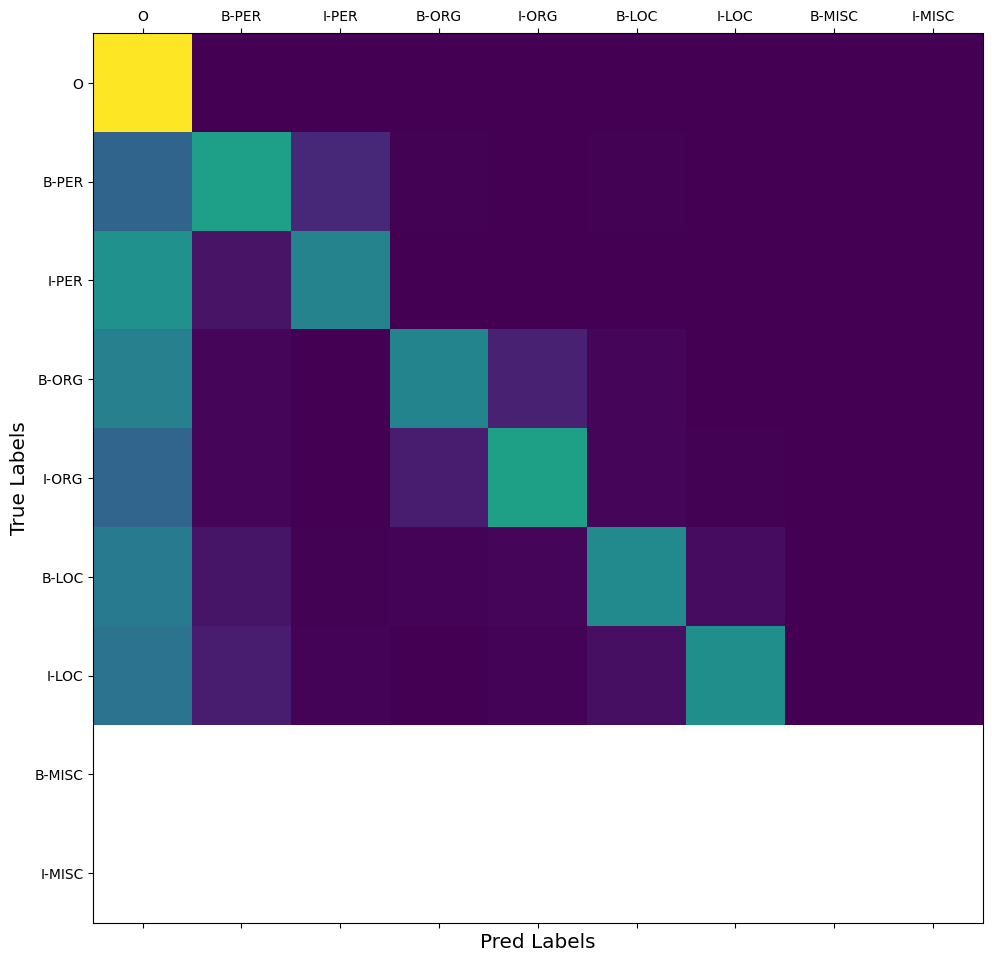

In [40]:
"""
Visualize the confusion matrix
"""
fig, ax = plt.subplots(figsize=(10, 10))
# visualize the loss values
ax.matshow(confusion.numpy())

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticks(ids)
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticks(ids)
ax.set_yticklabels(labels)

# plot figure
fig.tight_layout()
plt.show()

**Some observations:**

Based on the confusion matrix for each tag we can conclude that:
* Tokens with similar meanings are predicted by the model with similar tag pair (B-PER/I-PER, B-ORG/I-ORG, B-LOC/I-LOC) or tag O (means the word doesn’t correspond to any entity).

`The successful predictions of the classifier, the ones where the predicted class matches the true class are along the diagonal of the confusion matrix`

**How to solve these missmatches?**
* Increasing epoch number?